In [72]:
import zarr 
import numpy as np
import imageio
import os
import random
from skimage.segmentation import relabel_sequential
import matplotlib.pyplot as plt

In [73]:
# Helper functions
def crop_tiles(image, crop_size):
    #Function for convertion of large images into series of tiles stacked along the 0 axis
    h, w = image.shape
    h_tiles = (h + crop_size - 1) // crop_size  # ceil division
    v_tiles = (w + crop_size - 1) // crop_size

    # Padding
    pad_h = h_tiles * crop_size - h
    pad_w = v_tiles * crop_size - w
    if pad_h > 0 or pad_w > 0:
        image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')

    # Preallocate output array
    tiles = np.empty((h_tiles * v_tiles, crop_size, crop_size), dtype=image.dtype)

    idx = 0
    for i in range(h_tiles):
        for j in range(v_tiles):
            y_start = i * crop_size
            x_start = j * crop_size
            tiles[idx] = image[y_start:y_start + crop_size, x_start:x_start + crop_size]
            idx += 1

    return tiles

def relabel_and_compress (segmentation, start_index = 1):
    # This function sequentially relabelles instances of segmented objects and
    # compresses all class segmentation channels to 1
    for i in range (segmentation.shape[0]):
        if segmentation [i, :, :].max() > 0:
            segmentation [i, :, :] = relabel_sequential (segmentation [i, :, :], offset = start_index)[0]
            start_index = segmentation [i, :, :].max()
        else:
            segmentation [i, :, :] = segmentation [i, :, :]
    segmentation = segmentation.sum (axis = 0)
    return segmentation

def min_max_normalize (image):
    image = np.array (image)
    min = image.min()
    max = image.max()
    image = (image - min)/(max - min)
    return image

In [74]:
image_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/raw_1_channel_images/"
nft_segm_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft"
tiff_files = sorted([os.path.join(nft_segm_path, f) for f in os.listdir(nft_segm_path) if f.endswith('.tiff') or f.endswith('.tif')])
print (len (tiff_files))
print (tiff_files)

72
['/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_AD_NA19-386_XY01.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_AD_NA22-214_XY01.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_AD_NA22-225_XY02.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_CBD_NA15-124_XY02.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_CBD_NA22-093_XY01.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_CBD_NA22-298_XY01.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_PSP_NA15-202_XY01.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_PSP_NA16-271_XY01.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_PSP_NA16-271_XY05.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_PSP_NA22-298_XY04.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/FTL_PSP_NA22-298_XY05.tif', '/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2

In [75]:
conditions = ["AD", "CBD", "PSP"]
condition_files = {}
for condition in conditions:
    condition_files[condition] = [f for f in tiff_files if condition in f]

condition_files ["PSP"]
print (conditions)

['AD', 'CBD', 'PSP']


In [77]:
zarr_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/zarr_storage/"
test_zarr = zarr_path +"nft_256.zarr"
root = zarr.open(test_zarr, mode='w')

In [78]:
for condition, file_list in condition_files.items():
    # Create a group for each condition
    group = root.create_group(condition)
    # Loop through each image file in the list
    for fname in file_list:
        # Load the image as a NumPy array
        #Getting image name
        image_name = fname.split ("/")[-1]
        image = os.path.join (image_path, image_name)
        # Load the image as a NumPy array
        img = imageio.imread(image)
        nft = imageio.imread (fname)
        #Getting image shape
        image_shape = img.shape
        assert img.shape == nft.shape
        #Defining the shape of instant segmentation array
        

        

        # Create an image group inside the condition group
        group_fov = group.create_group(image_name)
        #Create source and target array for image
        group_fov.create_array(name = "x", data = img)
        group_fov.create_array (name = "y", data =nft)
        

/tmp/ipykernel_547446/485627508.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image)
/tmp/ipykernel_547446/485627508.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  nft = imageio.imread (fname)


In [79]:
for conditions in list (root.keys()):
    images = root [conditions].keys()
    for fov in images:
        fov_group = root [conditions][fov]
        x = root[conditions][fov] ["x"][:]
        y = root[conditions][fov]["y"][:].astype ("int16")

        
        x_normalized = min_max_normalize (x)
        x_cropped = crop_tiles (x_normalized, crop_size = 256)
        y_cropped = crop_tiles (y, crop_size = 256)
        fov_group.create_array (name = "x_cropped", data = x_cropped)
        fov_group.create_array (name = "y_cropped", data = y_cropped)
print ("zarr generation complete")

zarr generation complete


AD


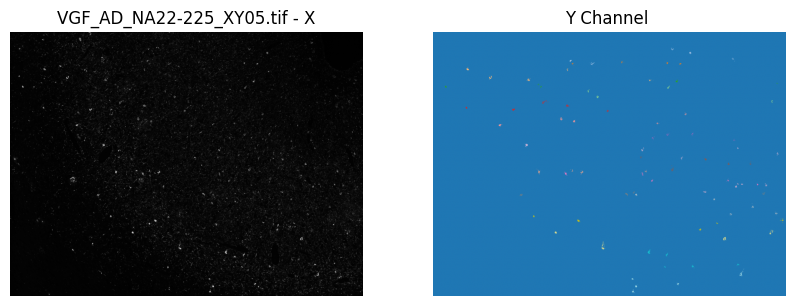

In [ ]:

    # Randomly pick a condition
condition = random.choice(list (root.keys()))
# condition = random.choice(conditions)
print (condition)
condition_group = root[condition]
    
#     # Randomly pick an image
image_name = random.choice(list(condition_group.keys()))
image_group = condition_group[image_name]
    
#     # Access x and y arrays

x = image_group["x"][:]      # Load x (H, W)
y = image_group["y"][:]      # Load y (C, H, W) or (H, W, C)

    
    
    
    # Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(x, cmap="gray")
axes[0].set_title(f"{image_name} - X")
axes[0].axis("off")
    
axes[1].imshow(y, cmap="tab20")
axes[1].set_title(f"Y Channel ")
axes[1].axis("off")
    
plt.show()

PSP
(165, 256, 256) (165, 256, 256)


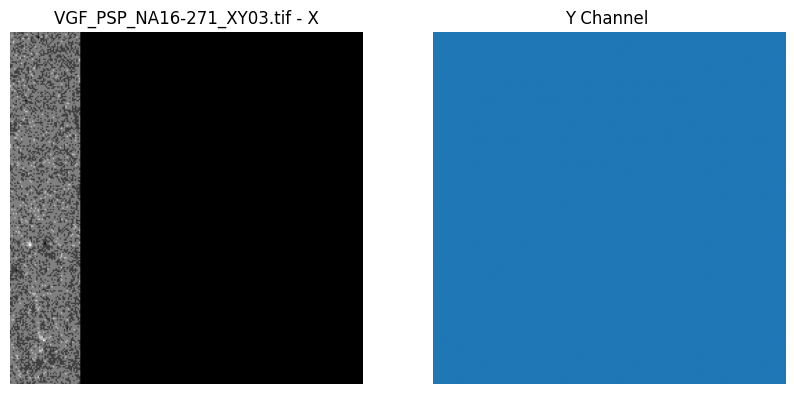

In [109]:
    # Randomly pick a condition
condition = random.choice(list (root.keys()))
# condition = random.choice(conditions)
print (condition)
condition_group = root[condition]
    
#     # Randomly pick an image
image_name = random.choice(list(condition_group.keys()))
image_group = condition_group[image_name]
    
#     # Access x and y arrays

x = image_group["x_cropped"][:]      # Load x (H, W)
y = image_group["y_cropped"][:]      # Load y (C, H, W) or (H, W, C)

print (x.shape, y.shape)

index = random.choice(range(0, 47))
x = x[index]
y = y [index]

    
    
    
    # Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(x, cmap="gray")
axes[0].set_title(f"{image_name} - X")
axes[0].axis("off")
    
axes[1].imshow(y, cmap="tab20")
axes[1].set_title(f"Y Channel ")
axes[1].axis("off")
    
plt.show()